In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

In [7]:
# print all the classes that automap found
print(Base.classes.keys())


['measurement', 'station']


In [8]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

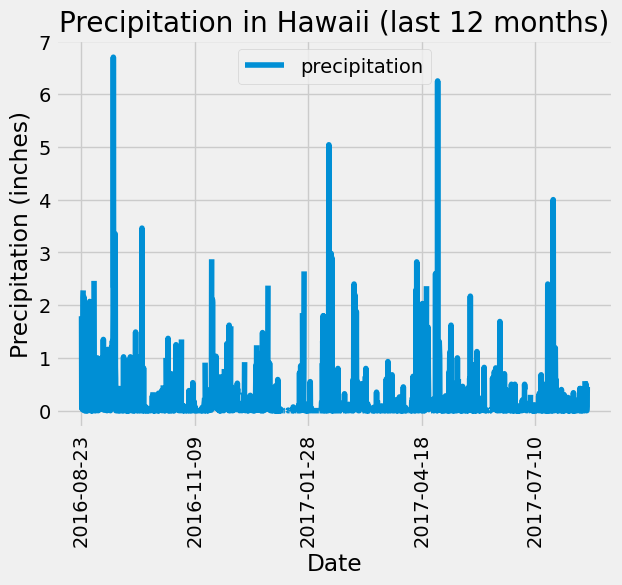

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.

# Convert query to a string
last_date_str = last_date[0]

#Split string
year, month, day = last_date_str.split("-")

#Get date
one_year_ago = dt.date(int(year), int(month), int(day)) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

prcp_query = session.query(measurement.date, measurement.prcp).\
            filter(measurement.date >= one_year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_query, columns=['date', 'precipitation'])

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data

# Set the index of the DataFrame to the date column
prcp_df.set_index('date', inplace=True)

# Plot the data
prcp_df.plot(rot=90)

# Add labels and a title
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation in Hawaii (last 12 months)")

# Show the plot
plt.show()



In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prcp_df.describe()
print(summary_stats)

       precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(func.count(station.station)).scalar()
num_stations

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Query to find the most active stations
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).all()

# Print the results
for station, count in active_stations:
    print(f"Station: {station} | Count: {count}")


Station: USC00519281 | Count: 2772
Station: USC00519397 | Count: 2724
Station: USC00513117 | Count: 2709
Station: USC00519523 | Count: 2669
Station: USC00516128 | Count: 2612
Station: USC00514830 | Count: 2202
Station: USC00511918 | Count: 1979
Station: USC00517948 | Count: 1372
Station: USC00518838 | Count: 511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Find most active station
most_active_station = session.query(measurement.station, func.count(measurement.station)) \
                             .group_by(measurement.station) \
                             .order_by(func.count(measurement.station).desc()) \
                             .first()[0]

#Find temps
lowest_temp = session.query(func.min(measurement.tobs)) \
                 .filter(measurement.station == most_active_station) \
                 .all()

highest_temp = session.query(func.max(measurement.tobs)) \
                 .filter(measurement.station == most_active_station) \
                 .all()

mean_temp = session.query(func.avg(measurement.tobs)) \
                 .filter(measurement.station == most_active_station) \
                 .all()

print(f"Lowest Temp: {lowest_temp}, Highest Temp: {highest_temp}, Average Temp: {mean_temp}")

Lowest Temp: [(54.0,)], Highest Temp: [(85.0,)], Average Temp: [(71.66378066378067,)]


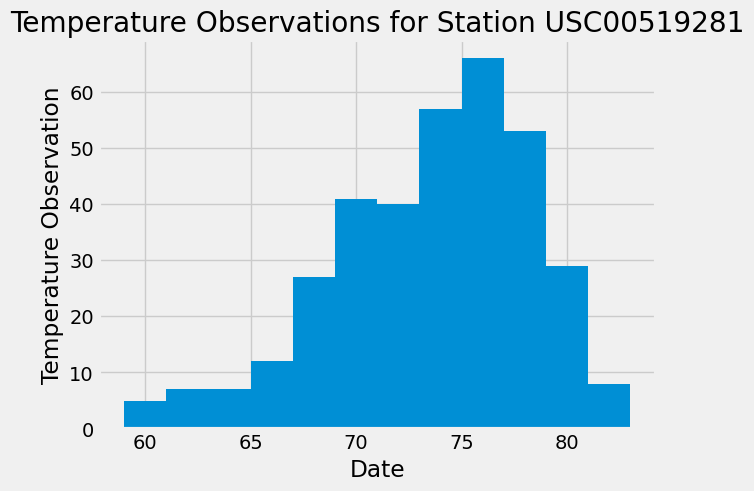

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Starting from the most recent data point in the database. 
last_date_temp = session.query(measurement.date).order_by(measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.

# Convert query to a string
last_date_temp_str = last_date_temp[0]

#Split string
year, month, day = last_date_temp_str.split("-")

#Get date of one year
one_year_ago_temp = dt.date(int(year), int(month), int(day)) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

temp_query = session.query(measurement.date, measurement.tobs).\
            filter(measurement.date >= one_year_ago_temp).\
            filter(measurement.station == most_active_station).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
temp_df = pd.DataFrame(temp_query, columns=['date', 'temperature observation'])

# Sort the dataframe by date
temp_df = temp_df.sort_values(by='date')

# Sort the dataframe by date and reset the index
temp_df = temp_df.sort_values(by='date').reset_index(drop=True)

# Plot the data as a histogram
temp_df.hist(column='temperature observation', bins=12)

# Add labels and a title
plt.xlabel("Date")
plt.ylabel("Temperature Observation")
plt.title(f"Temperature Observations for Station {most_active_station}")

# Show the plot
plt.show()


# Close Session

In [18]:
# Close Session
session.close()